In [8]:
import os
import numpy as np
from bitstring import Bits
import matplotlib.pyplot as plt

# ADC conversion parameters

In [9]:
DATAPATH = "data"
data = []

print(os.listdir(DATAPATH))

['INL_ideal_SW_ideal_CDAC.csv', 'sine_4.4725M_mismatch_1.csv', 'spectrum_4.91M_4096.csv', 'sine_4.4725M_2048.csv', 'spectrum_12.49M_4096.csv', 'INL_TG_ideal_CDAC.csv', 'out (1).csv', 'spectrum_4.47M_4096.csv', 'INL_mismatch_3_noisy.csv', 'spectrum_4.47M_4096_conservative.csv', 'spectrum_6.01M_4096_conservative.csv', 'spectrum_9.47M_4096_conservative.csv', 'sine_2.33M_2048.csv', 'spectrum_17.47M_4096_conservative.csv', 'spectrum_2.31M_4096.csv', 'test.csv', 'INL_enhanced_TG_ideal_CDAC.csv', 'sine_2.33M_512.csv', 'spectrum_27.53M_4096_conservative.csv', 'sine_0.31M_mismatch_1.csv', 'spectrum_6.01M_4096.csv', 'spectrum_3.31M_4096.csv', 'spectrum_8.53M_4096.csv', 'spectrum_0.31M_4096_conservative.csv', 'INL_pismatch_1_noisy_unbalance.csv', 'sine_4.4725M_2048_liberal.csv', 'spectrum_1.31M_4096.csv', 'histogram.csv', 'INL_mismatch_1_noisy.csv', 'spectrum_0.31M_4096.csv', 'spectrum_3.81M_4096.csv', 'sine_0.2303M_mismatch_1.csv', 'spectrum_12.97M_4096_conservative.csv']


In [115]:
with open(os.path.join(DATAPATH, "INL_mismatch_1_noisy.csv")) as f:
    data = f.readlines()

# Conversion curve

In [122]:
BIT_RESOLUTION = 8 # 8bit
bit_range = [-1 * 2**(BIT_RESOLUTION - 1), 2**(BIT_RESOLUTION - 1) - 1]

# Ideal conversion gain
# CONVERSION_GAIN = 0.5/256

# w/ gain calibration
CONVERSION_GAIN = (0.5 - 0.046)/256
OFFSET = 0.00025

# In this case, the measurement input is given by Vcm + Vin & Vcm - Vin
# Thus the LSB should be considered as twice than the conversion gain
LSB = CONVERSION_GAIN * 2

INPUT_RANGE_CUT = [52, 52]

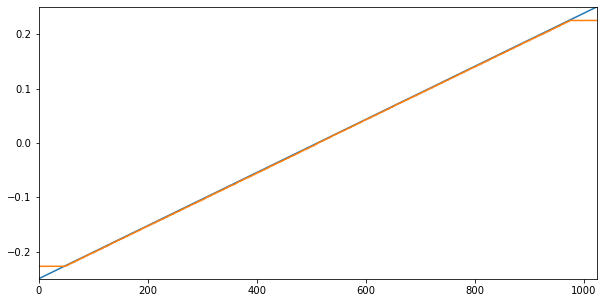

Input peak-2-peak range:  0.90


In [123]:
processed_data = np.zeros(shape=(len(data) - 1, 2))

for i in range(1, len(data)):
    temp = data[i].split(",0b")
    processed_data[i - 1, 0] = float(temp[0])
    processed_data[i - 1, 1] = Bits(bin=temp[1]).int

#print(processed_data)
plt.rcParams["figure.figsize"] = (10, 5)
plt.plot(processed_data[:,0])
plt.plot(CONVERSION_GAIN * processed_data[:,1])
plt.show()

min_input = processed_data[INPUT_RANGE_CUT[0],0]
max_input = processed_data[-1 *  INPUT_RANGE_CUT[1],0]

print("Input peak-2-peak range: {:5.2f}".format(2* (max_input - min_input)))

# INL

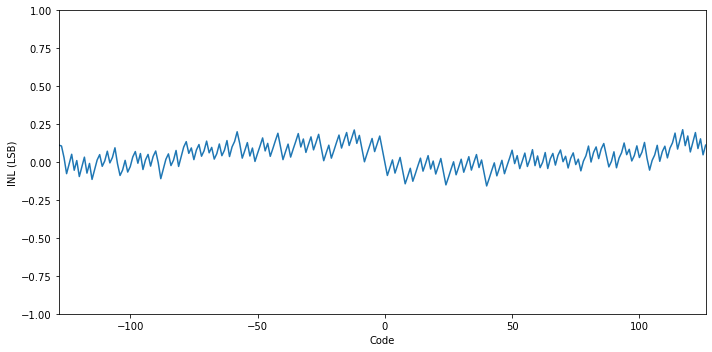

MAX INL:  0.2137
MIN INL: -0.1572


In [124]:
integrated_nonlinearity = np.ones(2**BIT_RESOLUTION - 1) * 100

for i in range(bit_range[0], bit_range[1]):
    for row in processed_data[INPUT_RANGE_CUT[0]:-INPUT_RANGE_CUT[1]]:
        if row[1] == i:
            integrated_nonlinearity[i + 2**(BIT_RESOLUTION - 1)] = (row[0] - OFFSET - i * CONVERSION_GAIN)/LSB
            break

for i in range(bit_range[0], bit_range[1]):
    if integrated_nonlinearity[i] == 100:
        integrated_nonlinearity[i] = integrated_nonlinearity[-1]

fig = plt.figure()

#print(integrated_nonlinearity)
plt.rcParams["figure.figsize"] = (7, 3)
plt.rcParams['axes.xmargin'] = 0
#plt.rcParams['axes.ymargin'] = 0
plt.ylim(-1,1)
plt.xlabel("Code")
plt.ylabel("INL (LSB)")
plt.plot(
    range(bit_range[0], bit_range[1]),
    integrated_nonlinearity)
plt.tight_layout()
plt.show()

print("MAX INL: {:7.4f}".format(max(integrated_nonlinearity[1:-1])))
print("MIN INL: {:7.4f}".format(min(integrated_nonlinearity[1:-1])))

# DNL

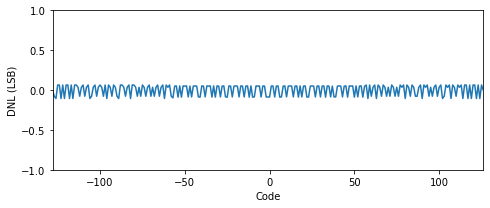

MAX DNL:  0.0639
MIN DNL: -0.1053


In [126]:
differential_nonlinearity = np.zeros_like(integrated_nonlinearity)
for i in range(len(integrated_nonlinearity) - 1):
    differential_nonlinearity[i] = integrated_nonlinearity[i + 1] - integrated_nonlinearity[i]

fig = plt.figure()
plt.rcParams["figure.figsize"] = (10, 3)
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.ylim(-1,1)
plt.xlabel("Code")
plt.ylabel("DNL (LSB)")
plt.plot(
    range(bit_range[0], bit_range[1]),
    differential_nonlinearity)
plt.tight_layout()
plt.show()

print("MAX DNL: {:7.4f}".format(max(differential_nonlinearity[1:-1])))
print("MIN DNL: {:7.4f}".format(min(differential_nonlinearity[1:-1])))